model train, finetune, test, visualization...

In [1]:
# basic
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

# project
from dataset.dataset_config import edge_index, edge_attr, week_steps, edge_adj_mat, C_origin
from dataset.dataset_config import converted_nodes, converted_edges, river_info # only for visualization (!!should not be used in training!!)
from dataset.traffic_dataset import TrafficDataset
from dataset.traffic_dataset import EDGE_INDEX, EDGE_ATTR
from utils.Trainer import Trainer
from utils.calculate_performance_index import calculate_performance_index
from utils.visualization import plot_mape_violin, visualize_predictions, add_tod_dow, plot_city_edge_mape, plot_dow_mape_violin_filtered

from models.baselines import GCNMLP, STGCN, MLPBASED, STGAT, STAEformer
from models.STLinear import STLinear
from models.STLinear_biased_models import STLinear_HopBiased, STLinear_SPE, compute_spe_torch


c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\torch_geometric\graphgym\config.py:19: UserWarning: Could not define global config object. Please install 'yacs' via 'pip install yacs' in order to use GraphGym
  warnings.warn("Could not define global config object. Please install "
c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\torch_geometric\graphgym\imports.py:14: UserWarning: Please install 'pytorch_lightning' via  'pip install pytorch_lightning' in order to use GraphGym
  warnings.warn("Please install 'pytorch_lightning' via  "


util function & class

In [ ]:
def generate_model(models, train_loader, DEVICE, SAVE_DIR, load=False):

    for name, ModelClass in models.items():
        # (1) Extract shape information from a batch
        x_sample, y_sample = next(iter(train_loader))
        _, T, E, D_in = x_sample.shape
        _, _, _, D_out = y_sample.shape
        n_pred = y_sample.size(1)

        # (2) Instantiate the model
        if name == "MLPBASED":
            model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                               hidden_dim=256, dropout=0.1)
        else:
            # Common constructor arguments for GCNMLP, STGCN, etc.
            kwargs = dict(
                num_nodes=E, node_feature_dim=D_in,
                pred_node_dim=D_out, n_pred=n_pred,
                encoder_embed_dim=32, encoder_depth=1,
                dropout=0.1
            )
            if name == "DCRNN":
                kwargs.update(K=2)
            elif name == "STGCN":
                kwargs.update(kernel_size=3, K=2)
            elif name == "GCNMLP":
                kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)
            elif name == "STGAT":
                kwargs.update(encoder_depth=2, kernel_size=3, heads=4)
            elif name == "STLinear_h1":
                kwargs = dict(num_nodes=50,
                              kernel_size=33,
                              num_layers=6, 
                              num_heads=1,
                              dropout=0.14
                )
            elif name == "STLinear_HopBiased":
                kwargs = dict(
                    num_nodes            = 50,    # number of edges
                    kernel_size          = 33,    # time series decomposition kernel size
                    in_steps             = 12,    # number of input steps
                    out_steps            = 3,     # number of prediction steps
                    steps_per_day        = 480,   # number of steps per day
                    input_dim            = 3,     # volume/density/flow
                    output_dim           = 3,     # prediction channels
                    input_embedding_dim  = 24,    # traffic → 24-dim embedding
                    tod_embedding_dim    = 24,    # time-of-day embedding
                    dow_embedding_dim    = 24,    # day-of-week embedding
                    spatial_embedding_dim= 0,     # unused in original
                    adaptive_embedding_dim= 80,   # adaptive embedding size
                    feed_forward_dim     = 256,   # FFN hidden dimension
                    num_heads            = 2,     # max_hop + 1 = 2, pure attention + hop bias
                    num_layers           = 6,     # number of repeated blocks
                    dropout              = 0.14,  # dropout rate
                    use_mixed_proj       = True   # final projection for prediction
                )
            elif name == "STLinear_SPE":
                kwargs = dict(
                    num_nodes=50,               # E
                    kernel_size=33,             # time series decomposition kernel
                    in_steps=12,                # past input steps (default)
                    out_steps=3,                # prediction steps (default)
                    steps_per_day=480,          # number of steps per day (default)
                    input_dim=3,                # volume/density/flow
                    output_dim=3,               # prediction channels
                    # ────────────────────────────────────────
                    # Same embedding sizes as STLinear_h1
                    input_embedding_dim=24,     # default for STLinear
                    tod_embedding_dim=24,
                    dow_embedding_dim=24,
                    spatial_embedding_dim=0,    # unused in original STLinear_h1
                    adaptive_embedding_dim=80,
                    # ────────────────────────────────────────
                    # SPE-related
                    spe_dim=32,                 # number of eigenvectors (p)
                    spe_out_dim=96,             # projection dimension from SPE
                    normalized_laplacian=False,
                    # ────────────────────────────────────────
                    # Spatial block settings (same as STLinear_h1)
                    feed_forward_dim=256,       # Self-Attention FFN hidden dim
                    num_heads=1,                # max_hop+1 = 1
                    num_layers=6,               # number of repeated blocks
                    dropout=0.14,               # dropout rate
                    use_mixed_proj=True
                )
            elif name == "STAEformer":
                kwargs = dict(
                    num_nodes=50,       
                    in_steps=12,           
                    out_steps=3,     
                    steps_per_day=480,      
                    input_dim=3,           
                    output_dim=3,           
                    input_embedding_dim    = 32,
                    tod_embedding_dim      = 32,
                    dow_embedding_dim      = 32,
                    spatial_embedding_dim  = 32,
                    adaptive_embedding_dim = 32,
                    feed_forward_dim       = 256,
                    num_heads              = 1,
                    num_layers             = 4,
                    dropout                = 0.073,
                    use_mixed_proj         = True
                )

            model = ModelClass(**kwargs)

        model = model.to(DEVICE)

    if load == True:
        ckpt_path = os.path.join(SAVE_DIR, f"{name}.pth")
        model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE, weights_only=True))
        model = model.to(DEVICE)
    return model

# MAPE
class MAPELoss(nn.Module):
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # prevent diverging MAPE when denomiator(true value) is too small
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


dataset

In [3]:
# prepare dataset
BATCH_SIZE = 256
WINDOW = 12                   # input length
N_PRED = 3                    # output length
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EDGE_INDEX = EDGE_INDEX.to(DEVICE)
EDGE_ATTR = EDGE_ATTR.to(DEVICE)

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C) (33600, 50, 3)
# train/valid split (8:2)

split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

model

In [4]:
DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'
PRED_OFFSETS = np.array([3, 6, 12])
T_TOTAL      = data.shape[0]        # total timesteps
SAVE_DIR     = "./checkpoints"      
os.makedirs(SAVE_DIR, exist_ok=True)

models = {
#    "GCNMLP":    GCNMLP,
#    "STGCN":     STGCN,
#    "MLPBASED":  MLPBASED,
#    "STGAT": STGAT,
#    "STAEformer": STAEformer,
#    "STLinear_h1": STLinear,
#    "STLinear_HopBiased": STLinear_HopBiased,
    "STLinear_SPE": STLinear_SPE
}

# generate model instance
model = generate_model(models, train_loader, DEVICE, SAVE_DIR)

# Training

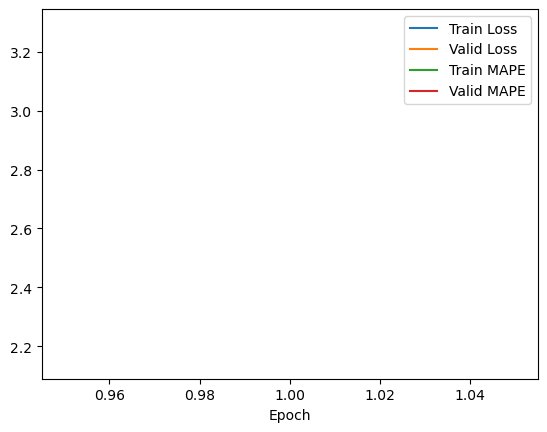

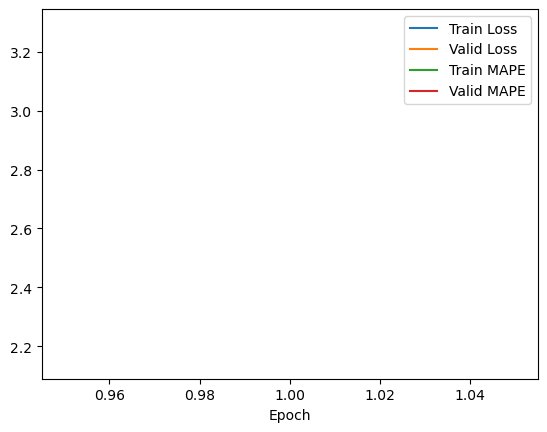

In [6]:
# Training
EPOCHS = 1 # for test
weight_decay = 1e-5
LEARNING_RATE = 2e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)
criterion = torch.nn.L1Loss()

# prepare trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=EPOCHS,
    device=DEVICE,
    auto_save=False,  # if you want, make it true
    save_dir=SAVE_DIR
)
trainer.fit()

fine tuning

In [ ]:
history = trainer.get_history()

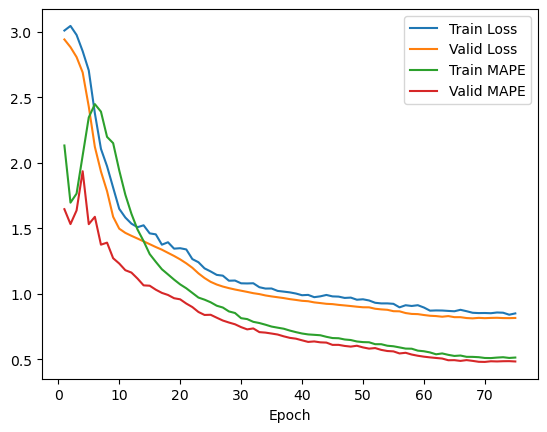

Early stopping at epoch 75


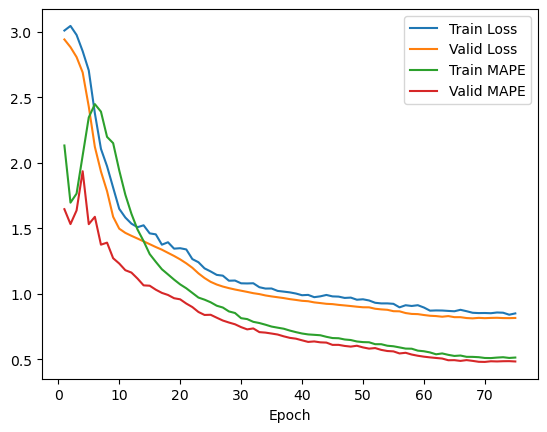

In [ ]:
# 1) Prepare Trainer (epochs=N means "number of additional training epochs")
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
trainer = Trainer(
    model, train_loader, valid_loader,
    optimizer, criterion,
    epochs=30, device=DEVICE,
    auto_save=True, save_dir="./checkpoints",
    early_stopping_patience=5
)

# 2) If preloaded weights and training history exist
trainer.load_checkpoint(
    state_dict   = torch.load("./checkpoints/EXAMPLE.pth"), # use your own path
    history      = history
)

# 3) Continue training
trainer.fit()

로드 및 시각화

In [5]:
models = {
#    "GCNMLP":    GCNMLP,
#    "STGCN":     STGCN,
#    "MLPBASED":  MLPBASED,
#    "STGAT": STGAT,
#    "STAEformer": STAEformer,
#    "STLinear_h1": STLinear,
#    "STLinear_HopBiased": STLinear_HopBiased,
    "STLinear_SPE": STLinear_SPE
}

model = generate_model(models, train_loader, DEVICE, SAVE_DIR, load=True) 
# assume that proper model weight is saved in SAVE_DIR
# name should be {model_class_name}.pth


--- Visualizing STLinear_SPE ---


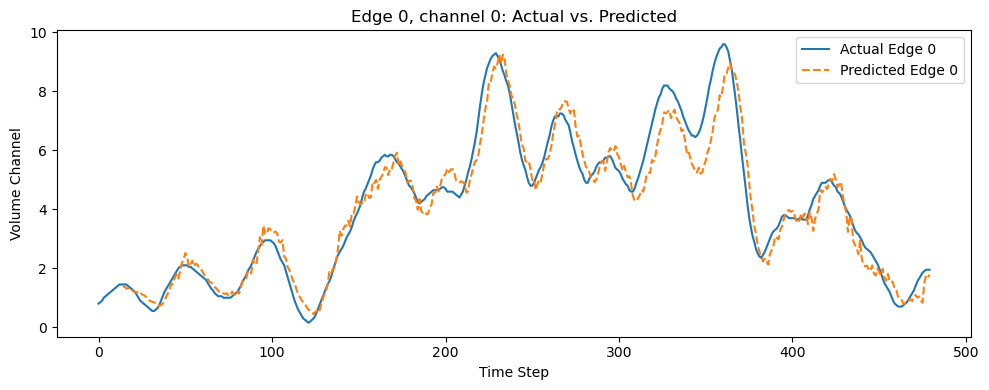

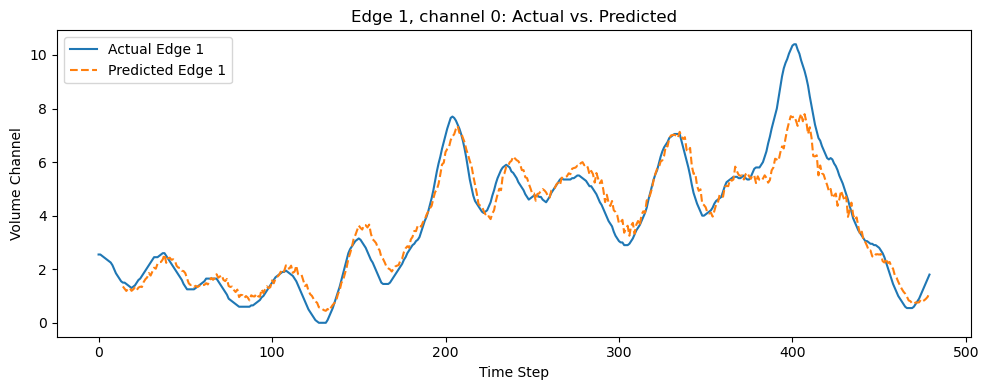

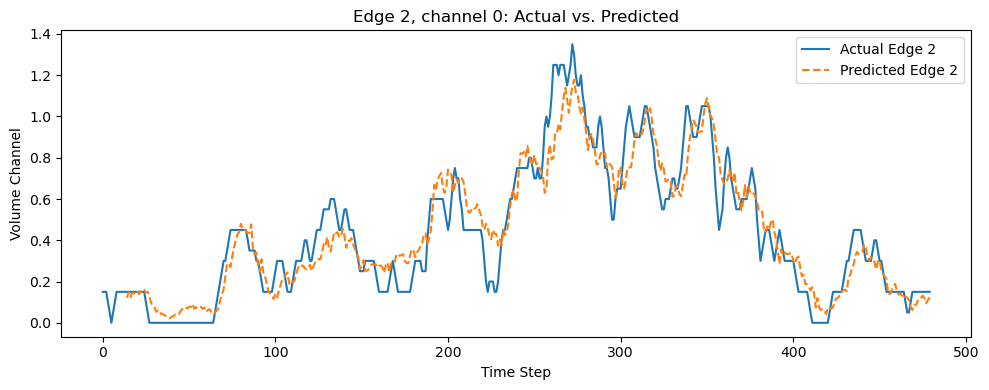

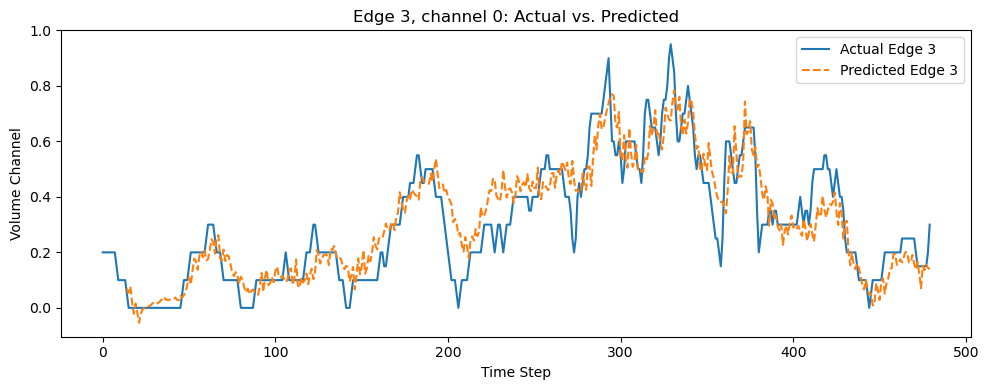

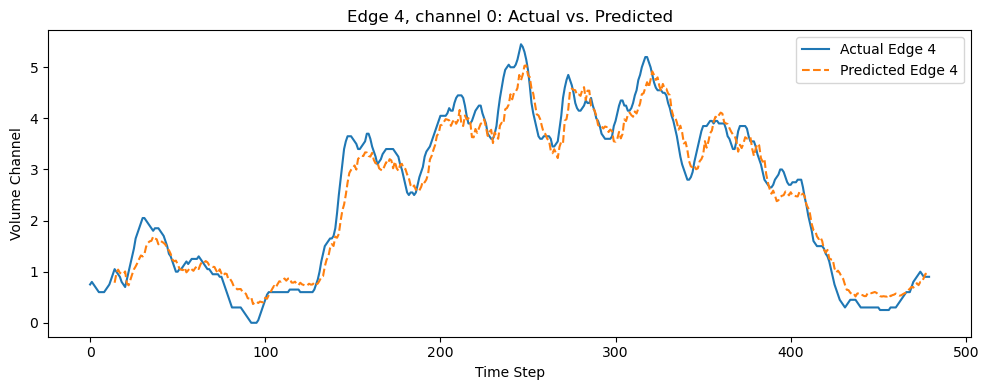

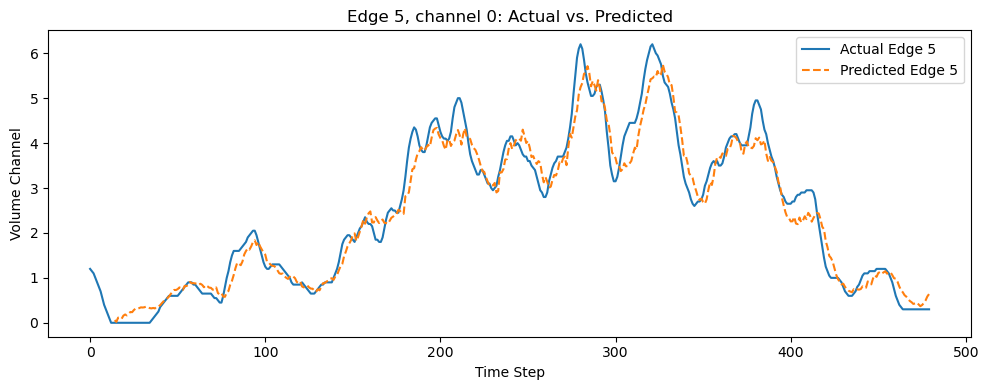

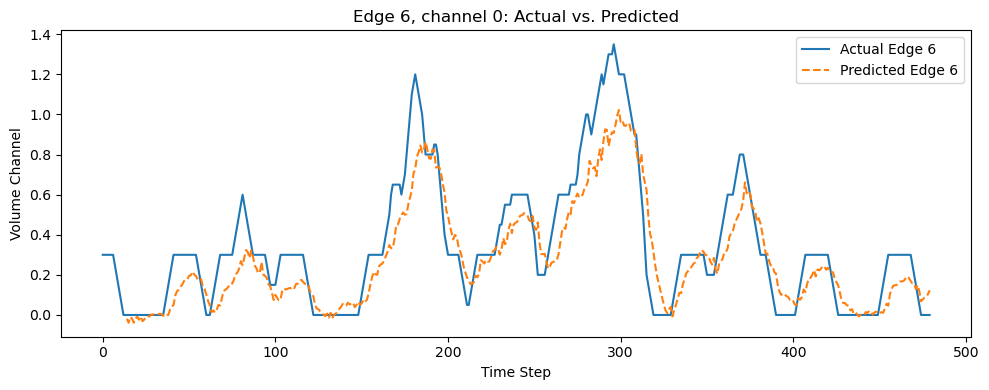

In [6]:
name = model.__class__.__name__
print(f"\n--- Visualizing {name} ---")
EDGE_IDS = [0,1,2,3,4,5,6]
expanded_data = add_tod_dow(data, week_steps=week_steps, C_origin=C_origin)
visualize_predictions(model, expanded_data, EDGE_IDS, DEVICE, EDGE_INDEX, EDGE_ATTR, interval=(480*5,480*6), channel=0)

In [7]:
calculate_performance_index(model, valid_loader, DEVICE, EDGE_INDEX, EDGE_ATTR)

Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]

Dataset size:      3337 samples
Average MAE:       0.6810
Average MSE:       6.1744
Average MAPE:      0.3967
Average RMSE:      2.4848


Step-wise MAPE:
  +3: mean=0.2782, std=0.0510
  +6: mean=0.3926, std=0.0678
  +12: mean=0.5406, std=0.0687
Channel-wise MAPE:
  volume: mean=0.3511, std=0.0530
  density: mean=0.5023, std=0.0844
  flow: mean=0.3576, std=0.0475
Overall MAPE: mean=0.4037, std=0.1106


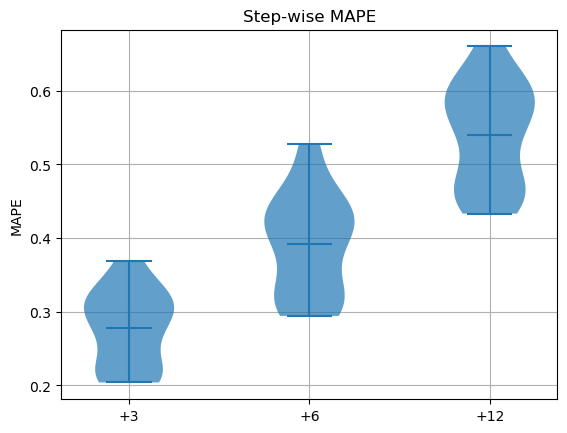

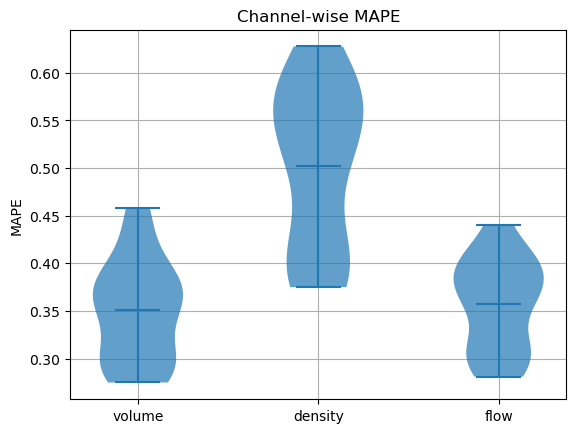

In [7]:
plot_mape_violin(model, valid_loader, DEVICE, edge_index, edge_attr)

100%|██████████| 53/53 [00:07<00:00,  7.29it/s]


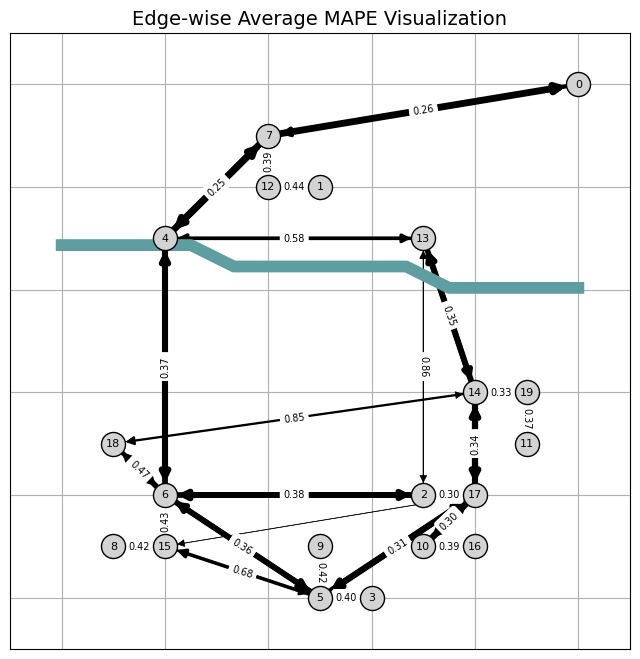

In [ ]:
plot_city_edge_mape(
    converted_nodes, converted_edges, river_info,
    valid_loader, model, DEVICE,
    edge_index, edge_attr,
    city_size=10
)

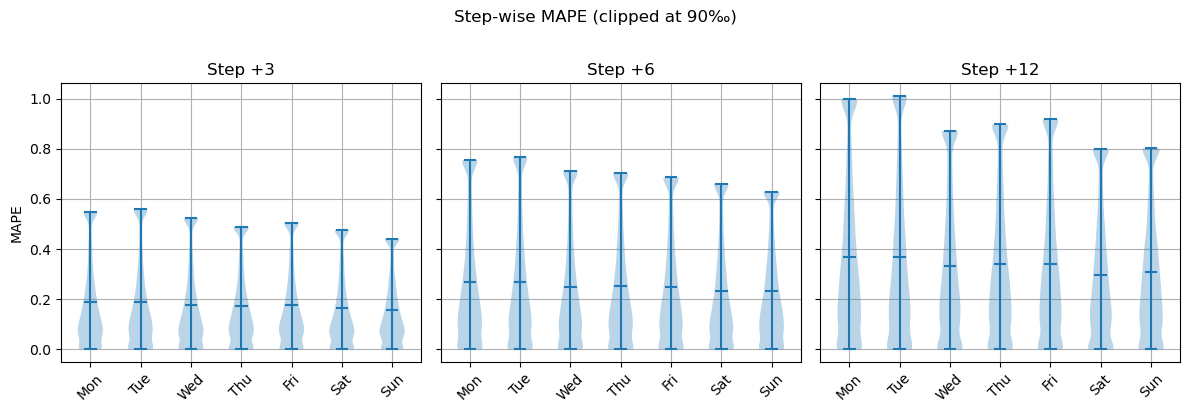

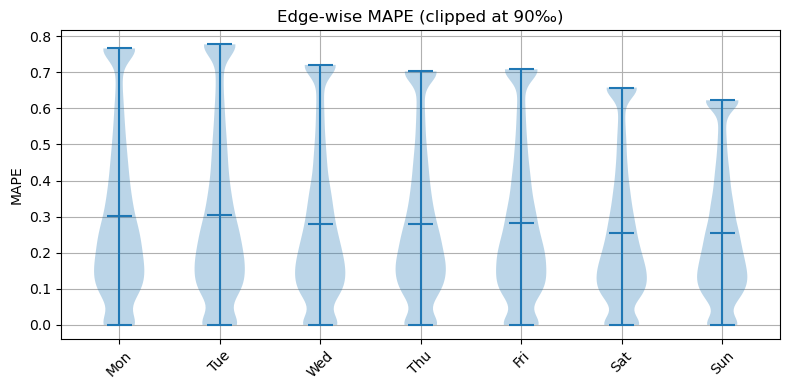

In [12]:
# assume that valid_loader, model, DEVICE, edge_index, edge_attr are prepared
plot_dow_mape_violin_filtered(
    valid_loader, model, DEVICE,
    edge_index, edge_attr,
    dow_idx=4,
    clip_percentile=90    # clipped at 95%
)